# Testing:

1. Try out the following classifiers and get the data loaded in a format that works for whatever classifier we're looking at. Do I need to sort back out the dictionaries?
    - RandomForestClassifier
    - Keras' building from scratch
1. Have fun and don't die

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from astropy.table import Table, Column
import h5py
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#transform the data, subtract off mean? make STDEV 1?
#

def read_hdf5_file(filename):
    truths = {} #extract the meta data! Our binary or not truths live here
    data = {} #extract the datasets, put their lightcurves here
    
    f = h5py.File(filename, 'r')
    
    for key in f.keys():
        #truths first
        for item in f[key].attrs:
            truths[key] = f[key].attrs[item]
        
        #extract LCs
        lcs = {}
        for i in range(len(f[key].dtype.descr)):
            lcs[f[key].dtype.descr[i][0]] = f[key][f[key].dtype.descr[i][0]]

        data[key] = lcs

    return data, truths

In [4]:
%%time
#it should take around 10 minutes for the smaller files with 10 datasets, depends on your computer
data, truths = read_hdf5_file("../Hackathon_2024_lcs_small.hdf5")

CPU times: user 8min 52s, sys: 20.2 s, total: 9min 12s
Wall time: 9min 13s


In [56]:
%%time
#it should take around 10 minutes for the smaller files with 10 datasets, depends on your computer
data_large, truths_large = read_hdf5_file("../Hackathon_2024_lcs_large.hdf5")

CPU times: user 28min 5s, sys: 55.3 s, total: 29min
Wall time: 29min 3s


In [71]:
#So I think I need arrays like [1000,100]
#1000 things that are 100 long
#so how about [1000, len(lc)]
#Then y_train is the truth table
X_train = np.zeros([1001,len(data['data0']["0"])])   
y_train = np.zeros(len(truths['data0']))
for i in range(0,len(truths['data0'])):
    #print(i)
    X_train[i,:] = data['data0'][str(i)]
    y_train[i] = truths['data0'][i]
#should I do it like this? no. But i'm going to anyways. I am tired.     
N = 30000    
X_train_N = np.zeros([N,len(data_large['data0']["0"])])   
y_train_N = np.zeros(N)
dataset_counter = 0
internal_counter = 0
for i in range(N):
    #print(internal_counter)
    #print(dataset_counter)
    if internal_counter >=1001:
#         print(internal_counter)
#         print(dataset_counter)
        internal_counter = 0
        dataset_counter += 1
    X_train_N[i,:] = data_large['data'+str(dataset_counter)][str(internal_counter)]
    #print(truths['data'+str(dataset_counter)][internal_counter])
    y_train_N[i] = truths_large['data'+str(dataset_counter)][internal_counter]
    internal_counter += 1
    

In [72]:
%%time
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train_N, y_train_N)

CPU times: user 29min 56s, sys: 1 s, total: 29min 57s
Wall time: 29min 58s


RandomForestClassifier(n_estimators=1000)

In [86]:
#copy pasta
N = 10000    
X_test_N = np.zeros([N,len(data['data0']["0"])])   
y_test_N = np.zeros(N)
dataset_counter = 0
internal_counter = 0
for i in range(N):
    if internal_counter >=1001:
        #print(internal_counter)
        #5print(dataset_counter)
        internal_counter = 0
        dataset_counter += 1
    X_test_N[i,:] = data['data'+str(dataset_counter)][str(internal_counter)]
    #print(truths['data'+str(dataset_counter)][internal_counter])
    y_test_N[i] = truths['data'+str(dataset_counter)][internal_counter]
    internal_counter += 1
# X_test = np.zeros([1001,len(data['data1']["0"])])   
# y_test = np.zeros(len(truths['data1']))
# for i in range(0,len(truths['data1'])):
#     #print(i)
#     X_test[i,:] = data['data1'][str(i)]
#     y_test[i] = truths['data1'][i]

In [87]:
%%time
y_pred = model.predict(X_test_N)
err = np.abs(y_pred - y_test_N)

CPU times: user 3.76 s, sys: 12.3 ms, total: 3.78 s
Wall time: 3.78 s


In [88]:
print(y_test_N[0:50])
print(y_pred[0:50])

[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0.]
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0.]


Random forest: 93.13% correct predictions


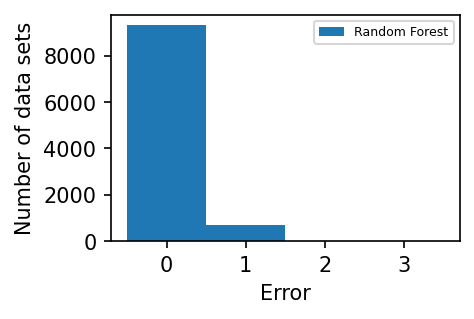

In [89]:
fig = plt.figure( figsize=(3,2), dpi=150 )
ax = fig.add_subplot(111)
ax.set_xlabel('Error')
ax.set_ylabel('Number of data sets')
#ax.set_title('Test set: k = %d' % k)
ax.hist(err, bins=np.arange(5)-0.5, label='Random Forest')
ax.legend(loc='best', prop={'size':6})

ind_forest = np.where(err == 0)[0]
print('Random forest: {:.2f}% correct predictions'.format(100.*ind_forest.size/len(err)))